In [142]:
from brian2 import *
import os
import re
import mne
# import numpy as np
import glob
import h5py
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from NeuroTools.parameters import ParameterSet, ParameterRange
from mne.time_frequency import tfr_multitaper
# from scipy.sparse import coo_matrix
# import pandas as pd
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# from scripts.simulation import simulate_network

## Basic Functions

In [2]:
def load_parameters(param_set_name):
    module = importlib.import_module(f'parameters.{param_set_name}')
    param_objects = {
        name: obj
        for name, obj in vars(module).items()
        if isinstance(obj, ParameterSet)
    }
    parameters = ParameterSet(param_objects)
    return parameters

In [3]:
def compute_erp_proxy(I_AMPA_error, I_GABA_error, I_AMPA_pred, I_GABA_pred, dt=0.1,
                      tau_ampa_error=0.9, tau_gaba_error=2.3,
                      tau_ampa_pred=1.2, tau_gaba_pred=3.0,
                      alpha=0.3):

    # Convert ms delays to timesteps
    shift_ampa_error  = int(tau_ampa_error / dt)
    shift_gaba_error = int(tau_gaba_error / dt)
    shift_ampa_pred = int(tau_ampa_pred / dt)
    shift_gaba_pred = int(tau_gaba_pred / dt)

    # Shift AMPA backward in time
    ampa_error_shifted = np.roll(I_AMPA_error, shift_ampa_error, axis=1)
    if shift_ampa_error > 0:
        ampa_error_shifted[:, :shift_ampa_error] = 0
    ampa_pred_shifted = np.roll(I_AMPA_pred, shift_ampa_pred, axis=1)
    if shift_ampa_pred > 0:
        ampa_pred_shifted[:, :shift_ampa_pred] = 0

    # Shift GABA forward in time
    gaba_error_shifted = np.roll(I_GABA_error, -shift_gaba_error, axis=1)
    if shift_gaba_error > 0:
        gaba_error_shifted[:, -shift_gaba_error:] = 0
    gaba_pred_shifted = np.roll(I_GABA_pred, -shift_gaba_pred, axis=1)
    if shift_gaba_pred > 0:
        gaba_pred_shifted[:, -shift_gaba_pred:] = 0

    # Sum over neurons
    ampa_total = np.sum(ampa_error_shifted, axis=0) + 0.8*np.sum(ampa_pred_shifted, axis=0)
    gaba_total = np.sum(gaba_error_shifted, axis=0) + 0.6*np.sum(gaba_pred_shifted, axis=0)

    # Final EEG proxy
    eeg_proxy = ampa_total - alpha*gaba_total

    return -eeg_proxy

In [4]:
def get_currents(simulation_trial, neuron_group='error'):
    I_AMPA = (simulation_trial['L1_monitors']['column_1'][neuron_group]['I_AMPA'] +
                simulation_trial['L1_monitors']['column_2'][neuron_group]['I_AMPA'] +
                simulation_trial['L2_monitors']['column_1'][neuron_group]['I_AMPA'] +
                simulation_trial['L2_monitors']['column_2'][neuron_group]['I_AMPA'] +
                simulation_trial['L3_monitors']['column_1'][neuron_group]['I_AMPA'] +
                simulation_trial['L3_monitors']['column_2'][neuron_group]['I_AMPA']
    )
    I_GABA = (simulation_trial['L1_monitors']['column_1'][neuron_group]['I_GABA'] +
                simulation_trial['L1_monitors']['column_2'][neuron_group]['I_GABA'] +
                simulation_trial['L2_monitors']['column_1'][neuron_group]['I_GABA'] +
                simulation_trial['L2_monitors']['column_2'][neuron_group]['I_GABA'] +
                simulation_trial['L3_monitors']['column_1'][neuron_group]['I_GABA'] +
                simulation_trial['L3_monitors']['column_2'][neuron_group]['I_GABA']
    )
    return I_AMPA, I_GABA

In [5]:
def get_sim_data(file):
    simulation_data = dict()
    with h5py.File(file, 'r') as f:
        for trial in f.keys():
            simulation_data[trial] = {}
            simulation_data[trial]['self_memory_weights'] = {}
            simulation_data[trial]['other_memory_weights'] = {}
            simulation_data[trial]['self_weight_connections'] = {}
            simulation_data[trial]['other_weight_connections'] = {}
            simulation_data[trial]['sim_time'] = f[trial]['sim_time'][:]*ms
            
            simulation_data[trial]['L1_monitors'] = {}
            for column in f[trial]['L1_monitors'].keys():
                simulation_data[trial]['L1_monitors'][column] = {}
                for neuron_group in f[trial]['L1_monitors'][column].keys():
                    if neuron_group == 'thalamic_stsd_term':
                        # simulation_data[trial]['L1_monitors'][column]['err_stsd_term'] = f[trial]['L1_monitors'][column]['err_stsd_term'][:]
                        continue
                    if neuron_group == 'err_stsd_term':
                        simulation_data[trial]['L1_monitors'][column]['err_stsd_term'] = f[trial]['L1_monitors'][column]['err_stsd_term'][:]
                        continue
                    simulation_data[trial]['L1_monitors'][column][neuron_group] = {}
                    simulation_data[trial]['L1_monitors'][column][neuron_group]['spike_indices'] = f[trial]['L1_monitors'][column][neuron_group]['spike_indices'][:]
                    simulation_data[trial]['L1_monitors'][column][neuron_group]['spike_times'] = f[trial]['L1_monitors'][column][neuron_group]['spike_times'][:]*ms
                    simulation_data[trial]['L1_monitors'][column][neuron_group]['rate'] = f[trial]['L1_monitors'][column][neuron_group]['rate'][:]*Hz
                    simulation_data[trial]['L1_monitors'][column][neuron_group]['I_AMPA'] = f[trial]['L1_monitors'][column][neuron_group]['I_AMPA'][:]*pA
                    simulation_data[trial]['L1_monitors'][column][neuron_group]['I_GABA'] = f[trial]['L1_monitors'][column][neuron_group]['I_GABA'][:]*pA
            
            simulation_data[trial]['L2_monitors'] = {}
            for column in f[trial]['L2_monitors'].keys():
                simulation_data[trial]['L2_monitors'][column] = {}
                for neuron_group in f[trial]['L2_monitors'][column].keys():
                    if neuron_group == 'err_stsd_term':
                        simulation_data[trial]['L2_monitors'][column]['err_stsd_term'] = f[trial]['L2_monitors'][column]['err_stsd_term'][:]
                        continue
                    simulation_data[trial]['L2_monitors'][column][neuron_group] = {}
                    simulation_data[trial]['L2_monitors'][column][neuron_group]['spike_indices'] = f[trial]['L2_monitors'][column][neuron_group]['spike_indices'][:]
                    simulation_data[trial]['L2_monitors'][column][neuron_group]['spike_times'] = f[trial]['L2_monitors'][column][neuron_group]['spike_times'][:]*ms
                    simulation_data[trial]['L2_monitors'][column][neuron_group]['rate'] = f[trial]['L2_monitors'][column][neuron_group]['rate'][:]*Hz
                    simulation_data[trial]['L2_monitors'][column][neuron_group]['I_AMPA'] = f[trial]['L2_monitors'][column][neuron_group]['I_AMPA'][:]*pA
                    simulation_data[trial]['L2_monitors'][column][neuron_group]['I_GABA'] = f[trial]['L2_monitors'][column][neuron_group]['I_GABA'][:]*pA
    
            
            simulation_data[trial]['L3_monitors'] = {}
            for column in f[trial]['L3_monitors'].keys():
                simulation_data[trial]['L3_monitors'][column] = {}
                if model == 'PC':
                    simulation_data[trial]['self_memory_weights'][column] = f[trial]['L3_monitors'][column]['self_weight_monitor'][:]
                    simulation_data[trial]['other_memory_weights'][column] = f[trial]['L3_monitors'][column]['other_weight_monitor'][:]
                    simulation_data[trial]['self_weight_connections'][column] = f[trial]['L3_monitors'][column]['self_weight_connections'][:]
                    simulation_data[trial]['other_weight_connections'][column] = f[trial]['L3_monitors'][column]['other_weight_connections'][:]
                if model == 'SA':
                    simulation_data[trial]['L3_monitors'][column]['err_stsd_term'] = f[trial]['L3_monitors'][column]['err_stsd_term'][:]
                for neuron_group in f[trial]['L3_monitors'][column].keys():
                    if neuron_group in ['err_stsd_term','self_weight_monitor','other_weight_monitor','self_weight_connections','other_weight_connections']:
                        continue
                    simulation_data[trial]['L3_monitors'][column][neuron_group] = {}
                    simulation_data[trial]['L3_monitors'][column][neuron_group]['spike_indices'] = f[trial]['L3_monitors'][column][neuron_group]['spike_indices'][:]
                    simulation_data[trial]['L3_monitors'][column][neuron_group]['spike_times'] = f[trial]['L3_monitors'][column][neuron_group]['spike_times'][:]*ms
                    simulation_data[trial]['L3_monitors'][column][neuron_group]['rate'] = f[trial]['L3_monitors'][column][neuron_group]['rate'][:]*Hz
                    simulation_data[trial]['L3_monitors'][column][neuron_group]['I_AMPA'] = f[trial]['L3_monitors'][column][neuron_group]['I_AMPA'][:]*pA
                    simulation_data[trial]['L3_monitors'][column][neuron_group]['I_GABA'] = f[trial]['L3_monitors'][column][neuron_group]['I_GABA'][:]*pA
    
            
            simulation_data[trial]['memory_networks'] = {}
            for net in f[trial]['memory_monitors'].keys():
                simulation_data[trial]['memory_networks'][net] = {}
                simulation_data[trial]['memory_networks'][net]['spike_indices'] = f[trial]['memory_monitors'][net]['spike_indices'][:]
                simulation_data[trial]['memory_networks'][net]['spike_times'] = f[trial]['memory_monitors'][net]['spike_times'][:]*ms
                simulation_data[trial]['memory_networks'][net]['rate'] = f[trial]['memory_monitors'][net]['rate'][:]*Hz
                simulation_data[trial]['memory_networks'][net]['I_AMPA'] = f[trial]['memory_monitors'][net]['I_AMPA'][:]*pA
                simulation_data[trial]['memory_networks'][net]['I_GABA'] = f[trial]['memory_monitors'][net]['I_GABA'][:]*pA
    return simulation_data

In [40]:
def get_currents_data(file):
    simulation_data = dict()
    with h5py.File(file, 'r') as f:
        for trial in f.keys():
            simulation_data[trial] = {}
            simulation_data[trial]['sim_time'] = f[trial]['sim_time'][:]*ms
            
            simulation_data[trial]['L1_monitors'] = {}
            for column in f[trial]['L1_monitors'].keys():
                simulation_data[trial]['L1_monitors'][column] = {}
                for neuron_group in f[trial]['L1_monitors'][column].keys():
                    if neuron_group == 'thalamic_stsd_term':
                        continue
                    if neuron_group == 'err_stsd_term':
                        continue
                    simulation_data[trial]['L1_monitors'][column][neuron_group] = {}
                    simulation_data[trial]['L1_monitors'][column][neuron_group]['I_AMPA'] = f[trial]['L1_monitors'][column][neuron_group]['I_AMPA'][:]*pA
                    simulation_data[trial]['L1_monitors'][column][neuron_group]['I_GABA'] = f[trial]['L1_monitors'][column][neuron_group]['I_GABA'][:]*pA
            
            simulation_data[trial]['L2_monitors'] = {}
            for column in f[trial]['L2_monitors'].keys():
                simulation_data[trial]['L2_monitors'][column] = {}
                for neuron_group in f[trial]['L2_monitors'][column].keys():
                    if neuron_group == 'err_stsd_term':
                        continue
                    simulation_data[trial]['L2_monitors'][column][neuron_group] = {}
                    simulation_data[trial]['L2_monitors'][column][neuron_group]['I_AMPA'] = f[trial]['L2_monitors'][column][neuron_group]['I_AMPA'][:]*pA
                    simulation_data[trial]['L2_monitors'][column][neuron_group]['I_GABA'] = f[trial]['L2_monitors'][column][neuron_group]['I_GABA'][:]*pA
    
            
            simulation_data[trial]['L3_monitors'] = {}
            for column in f[trial]['L3_monitors'].keys():
                simulation_data[trial]['L3_monitors'][column] = {}
                for neuron_group in f[trial]['L3_monitors'][column].keys():
                    if neuron_group in ['err_stsd_term','self_weight_monitor','lat_weight_monitor','self_weight_connections','lat_weight_connections']:
                        continue
                    simulation_data[trial]['L3_monitors'][column][neuron_group] = {}
                    simulation_data[trial]['L3_monitors'][column][neuron_group]['I_AMPA'] = f[trial]['L3_monitors'][column][neuron_group]['I_AMPA'][:]*pA
                    simulation_data[trial]['L3_monitors'][column][neuron_group]['I_GABA'] = f[trial]['L3_monitors'][column][neuron_group]['I_GABA'][:]*pA

    return simulation_data

## Single Simulation Analysis

In [187]:
model='CO'
N = 40
num_simulations = 1
# simulation_folder = 'higher_conn'
simulation_folder = '/'
simulation_time = 1.8*second
stimulus_time=20*ms
smoothing_width=20*ms

impulse_times = np.arange(400, 1500, 200)*ms
deviant_times = np.array([1400])*ms

params = load_parameters('sa_parameters_ranged')

list_of_files = glob.glob(f'./simulation_data/{simulation_folder}/{model}*', recursive=True)
latest_file = max(list_of_files, key=os.path.getctime)
print(f'Opening file: {latest_file}')

simulation_data = dict()
with h5py.File(latest_file, 'r') as f:
    for trial in f.keys():
        simulation_data[trial] = {}
        simulation_data[trial]['self_memory_weights'] = {}
        simulation_data[trial]['lat_memory_weights'] = {}
        simulation_data[trial]['self_weight_connections'] = {}
        simulation_data[trial]['lat_weight_connections'] = {}
        simulation_data[trial]['sim_time'] = f[trial]['sim_time'][:]*ms
        
        simulation_data[trial]['L1_monitors'] = {}
        for column in f[trial]['L1_monitors'].keys():
            simulation_data[trial]['L1_monitors'][column] = {}
            for neuron_group in f[trial]['L1_monitors'][column].keys():
                if neuron_group == 'thalamic_stsd_term':
                    # simulation_data[trial]['L1_monitors'][column]['err_stsd_term'] = f[trial]['L1_monitors'][column]['err_stsd_term'][:]
                    continue
                if neuron_group == 'err_stsd_term':
                    simulation_data[trial]['L1_monitors'][column]['err_stsd_term'] = f[trial]['L1_monitors'][column]['err_stsd_term'][:]
                    continue
                simulation_data[trial]['L1_monitors'][column][neuron_group] = {}
                simulation_data[trial]['L1_monitors'][column][neuron_group]['spike_indices'] = f[trial]['L1_monitors'][column][neuron_group]['spike_indices'][:]
                simulation_data[trial]['L1_monitors'][column][neuron_group]['spike_times'] = f[trial]['L1_monitors'][column][neuron_group]['spike_times'][:]*ms
                simulation_data[trial]['L1_monitors'][column][neuron_group]['rate'] = f[trial]['L1_monitors'][column][neuron_group]['rate'][:]*Hz
                simulation_data[trial]['L1_monitors'][column][neuron_group]['I_AMPA'] = f[trial]['L1_monitors'][column][neuron_group]['I_AMPA'][:]*pA
                simulation_data[trial]['L1_monitors'][column][neuron_group]['I_GABA'] = f[trial]['L1_monitors'][column][neuron_group]['I_GABA'][:]*pA
        
        simulation_data[trial]['L2_monitors'] = {}
        for column in f[trial]['L2_monitors'].keys():
            simulation_data[trial]['L2_monitors'][column] = {}
            for neuron_group in f[trial]['L2_monitors'][column].keys():
                if neuron_group == 'err_stsd_term':
                    simulation_data[trial]['L2_monitors'][column]['err_stsd_term'] = f[trial]['L2_monitors'][column]['err_stsd_term'][:]
                    continue
                simulation_data[trial]['L2_monitors'][column][neuron_group] = {}
                simulation_data[trial]['L2_monitors'][column][neuron_group]['spike_indices'] = f[trial]['L2_monitors'][column][neuron_group]['spike_indices'][:]
                simulation_data[trial]['L2_monitors'][column][neuron_group]['spike_times'] = f[trial]['L2_monitors'][column][neuron_group]['spike_times'][:]*ms
                simulation_data[trial]['L2_monitors'][column][neuron_group]['rate'] = f[trial]['L2_monitors'][column][neuron_group]['rate'][:]*Hz
                simulation_data[trial]['L2_monitors'][column][neuron_group]['I_AMPA'] = f[trial]['L2_monitors'][column][neuron_group]['I_AMPA'][:]*pA
                simulation_data[trial]['L2_monitors'][column][neuron_group]['I_GABA'] = f[trial]['L2_monitors'][column][neuron_group]['I_GABA'][:]*pA

    
        simulation_data[trial]['L3_monitors'] = {}
        for column in f[trial]['L3_monitors'].keys():
            simulation_data[trial]['L3_monitors'][column] = {}
            if model == 'PC' or model=='CO':
                simulation_data[trial]['self_memory_weights'][column] = f[trial]['L3_monitors'][column]['self_weight_monitor'][:]
                simulation_data[trial]['lat_memory_weights'][column] = f[trial]['L3_monitors'][column]['lat_weight_monitor'][:]
                simulation_data[trial]['self_weight_connections'][column] = f[trial]['L3_monitors'][column]['self_weight_connections'][:]
                simulation_data[trial]['lat_weight_connections'][column] = f[trial]['L3_monitors'][column]['lat_weight_connections'][:]
            if model == 'SA':
                simulation_data[trial]['L3_monitors'][column]['err_stsd_term'] = f[trial]['L3_monitors'][column]['err_stsd_term'][:]
            for neuron_group in f[trial]['L3_monitors'][column].keys():
                if neuron_group in ['err_stsd_term','self_weight_monitor','lat_weight_monitor','self_weight_connections','lat_weight_connections']:
                    continue
                simulation_data[trial]['L3_monitors'][column][neuron_group] = {}
                simulation_data[trial]['L3_monitors'][column][neuron_group]['spike_indices'] = f[trial]['L3_monitors'][column][neuron_group]['spike_indices'][:]
                simulation_data[trial]['L3_monitors'][column][neuron_group]['spike_times'] = f[trial]['L3_monitors'][column][neuron_group]['spike_times'][:]*ms
                simulation_data[trial]['L3_monitors'][column][neuron_group]['rate'] = f[trial]['L3_monitors'][column][neuron_group]['rate'][:]*Hz
                simulation_data[trial]['L3_monitors'][column][neuron_group]['I_AMPA'] = f[trial]['L3_monitors'][column][neuron_group]['I_AMPA'][:]*pA
                simulation_data[trial]['L3_monitors'][column][neuron_group]['I_GABA'] = f[trial]['L3_monitors'][column][neuron_group]['I_GABA'][:]*pA

        
        simulation_data[trial]['memory_networks'] = {}
        for net in f[trial]['memory_monitors'].keys():
            simulation_data[trial]['memory_networks'][net] = {}
            simulation_data[trial]['memory_networks'][net]['spike_indices'] = f[trial]['memory_monitors'][net]['spike_indices'][:]
            simulation_data[trial]['memory_networks'][net]['spike_times'] = f[trial]['memory_monitors'][net]['spike_times'][:]*ms
            simulation_data[trial]['memory_networks'][net]['rate'] = f[trial]['memory_monitors'][net]['rate'][:]*Hz
            simulation_data[trial]['memory_networks'][net]['I_AMPA'] = f[trial]['memory_monitors'][net]['I_AMPA'][:]*pA
            simulation_data[trial]['memory_networks'][net]['I_GABA'] = f[trial]['memory_monitors'][net]['I_GABA'][:]*pA

Opening file: ./simulation_data\CO_2025_04_28-16_41_30.hdf5


### Plot STDP Weights

In [188]:
trial = 'Trial_1'

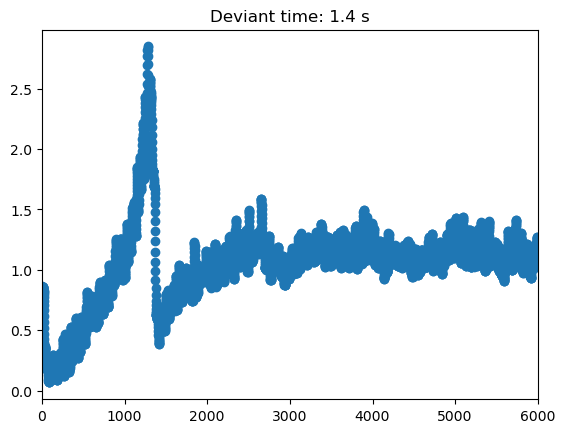

In [189]:
for deviant_time in deviant_times:
    index = np.where(impulse_times == deviant_time)[0][0]
    index=-1
    smoothed_weights = gaussian_filter1d(simulation_data[trial]['self_memory_weights']['column_1'][index, :], sigma=5)
    plt.figure()
    plt.scatter(np.arange(simulation_data[trial]['self_memory_weights']['column_1'][index, :].shape[0]),
            smoothed_weights)
    plt.xlim(0, 6000)
    plt.title(f'Deviant time: {deviant_time}')

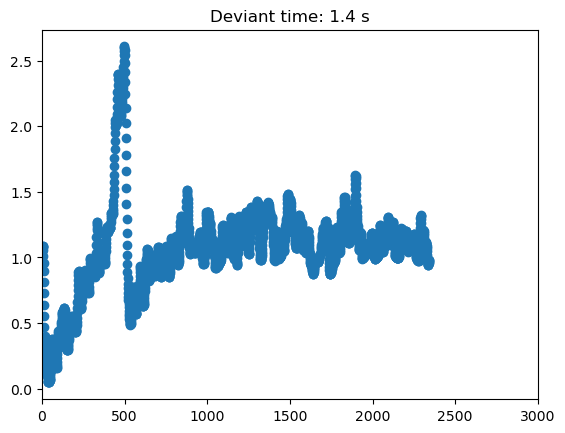

In [190]:
for deviant_time in deviant_times:
    index = np.where(impulse_times == deviant_time)[0][0]
    index=-1
    smoothed_weights = gaussian_filter1d(simulation_data[trial]['lat_memory_weights']['column_1'][index, :], sigma=5)
    plt.figure()
    plt.scatter(np.arange(simulation_data[trial]['lat_memory_weights']['column_1'][index, :].shape[0]),
            smoothed_weights)
    plt.xlim(0, 3000)
    plt.title(f'Deviant time: {deviant_time}')

### Population Rate Plot

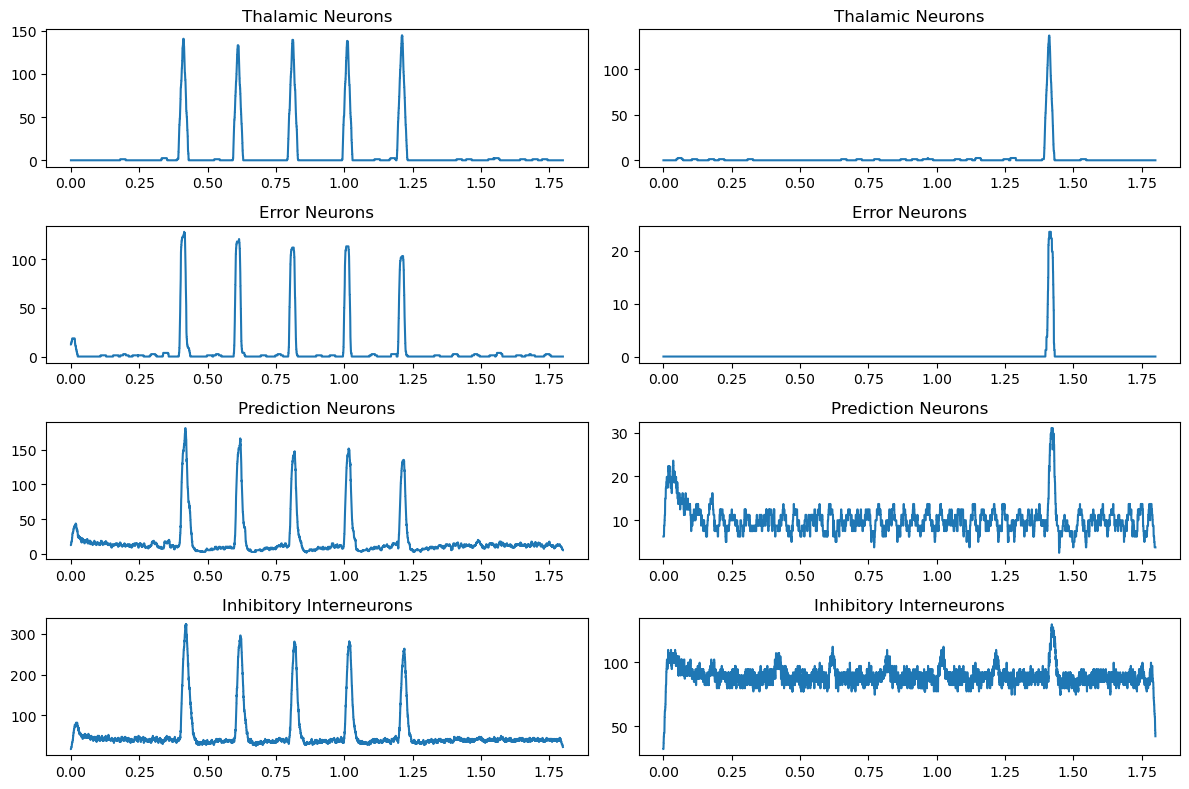

In [191]:
# Level-1
neuron_types = ['thalamic', 'error', 'prediction', 'interneurons']
titles = ['Thalamic Neurons', 'Error Neurons', 'Prediction Neurons', 'Inhibitory Interneurons']

plt.figure(figsize=(12, 8))
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time'], 
         simulation_data[trial]['L1_monitors']['column_1'][neuron_type]['rate'])
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time'], 
         simulation_data[trial]['L1_monitors']['column_2'][neuron_type]['rate'])
    plt.title(titles[i])
plt.tight_layout()

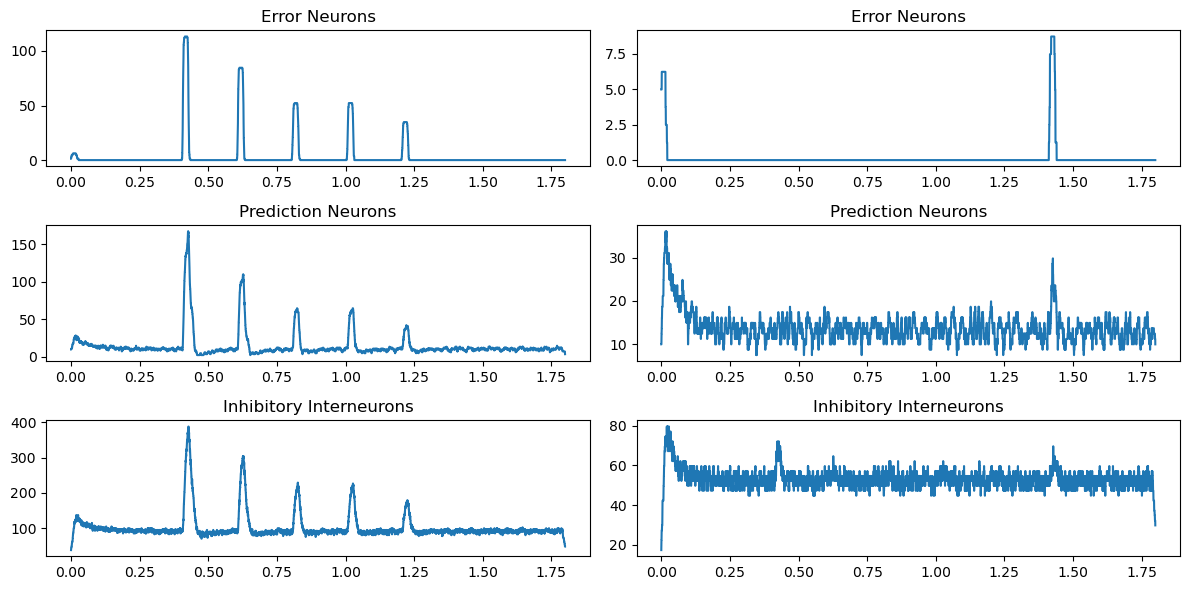

In [192]:
# Level-2
neuron_types = ['error', 'prediction', 'interneurons']
titles = ['Error Neurons', 'Prediction Neurons', 'Inhibitory Interneurons']

plt.figure(figsize=(12, 6))
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(3, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time'], 
         simulation_data[trial]['L2_monitors']['column_1'][neuron_type]['rate'])
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(3, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time'], 
         simulation_data[trial]['L2_monitors']['column_2'][neuron_type]['rate'])
    plt.title(titles[i])
plt.tight_layout()

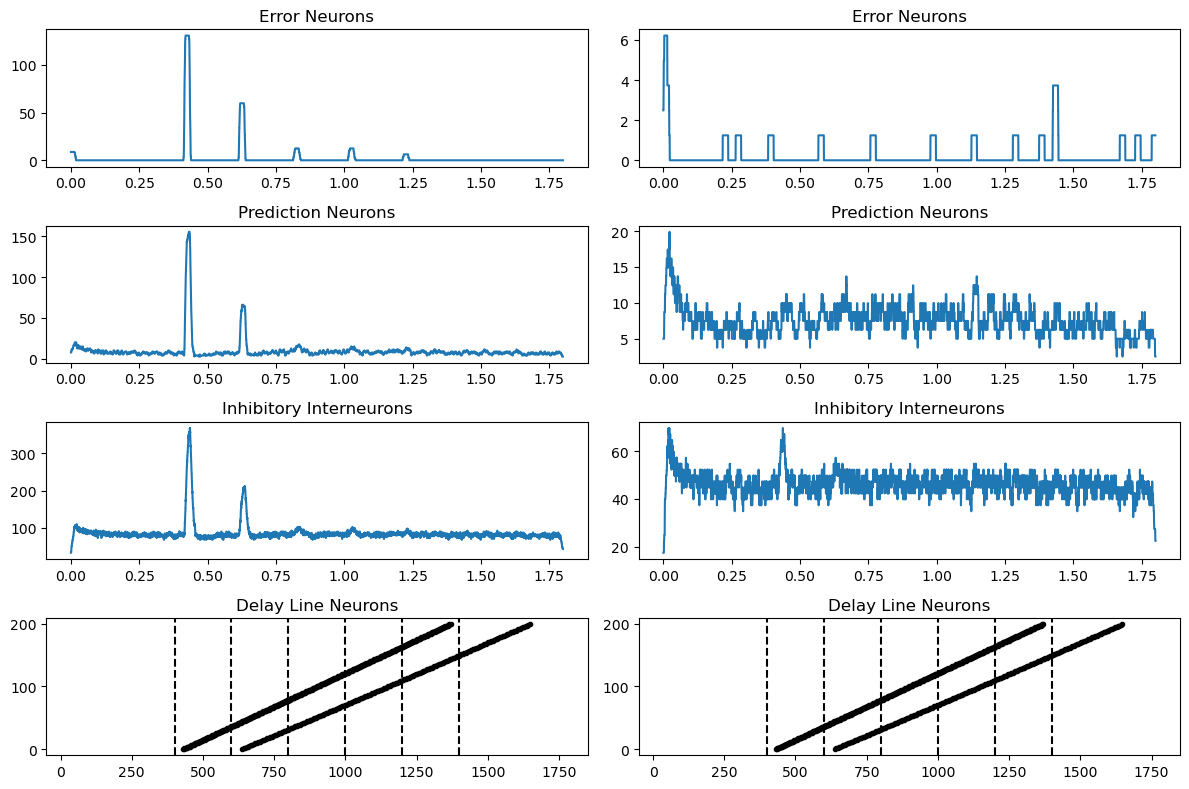

In [194]:
# Level-3
neuron_types = ['error', 'prediction', 'interneurons']
titles = ['Error Neurons', 'Prediction Neurons', 'Inhibitory Interneurons']

plt.figure(figsize=(12, 8))

for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time'], 
         simulation_data[trial]['L3_monitors']['column_1'][neuron_type]['rate'])
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time'], 
         simulation_data[trial]['L3_monitors']['column_2'][neuron_type]['rate'])
    plt.title(titles[i])

# Plot the spikes of the delay line neurons
plt.subplot(4,2,7)
plot(simulation_data[trial]['memory_networks']['memory_network_1']['spike_times']/ms,
     simulation_data[trial]['memory_networks']['memory_network_1']['spike_indices'], '.k')
for time in impulse_times:
    plt.axvline(time/ms, c='k', ls='--')
plt.title('Delay Line Neurons')
plt.xlim(-50, simulation_time/ms + 50)

plt.subplot(4,2,8)
plot(simulation_data[trial]['memory_networks']['memory_network_2']['spike_times']/ms,
     simulation_data[trial]['memory_networks']['memory_network_2']['spike_indices'], '.k')
for time in impulse_times:
    plt.axvline(time/ms, c='k', ls='--')
plt.title('Delay Line Neurons')
plt.xlim(-50, simulation_time/ms + 50)
plt.tight_layout()

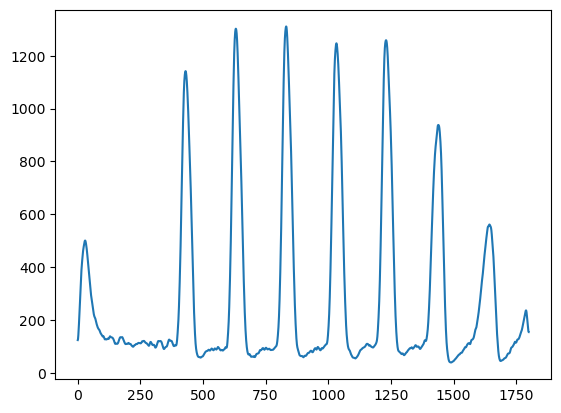

In [133]:
# Combined rate
combined_rate = np.zeros(round(simulation_time/defaultclock.dt))*Hz
combined_rate += (simulation_data[trial]['L1_monitors']['column_1']['error']['rate'] + \
                 simulation_data[trial]['L1_monitors']['column_2']['error']['rate'] + \
                 simulation_data[trial]['L2_monitors']['column_1']['error']['rate'] + \
                 simulation_data[trial]['L2_monitors']['column_2']['error']['rate'] + \
                 simulation_data[trial]['L3_monitors']['column_1']['error']['rate'] + \
                 simulation_data[trial]['L3_monitors']['column_2']['error']['rate'] + \
                 simulation_data[trial]['L1_monitors']['column_1']['prediction']['rate'] + \
                 simulation_data[trial]['L1_monitors']['column_2']['prediction']['rate'] + \
                 simulation_data[trial]['L2_monitors']['column_1']['prediction']['rate'] + \
                 simulation_data[trial]['L2_monitors']['column_2']['prediction']['rate'] + \
                 simulation_data[trial]['L3_monitors']['column_1']['prediction']['rate'] + \
                 simulation_data[trial]['L3_monitors']['column_2']['prediction']['rate']
                 )/num_simulations
time_axis = simulation_data[trial]['sim_time']/ms

combined_rate = gaussian_filter1d(combined_rate, sigma=20)
plot(time_axis, combined_rate);

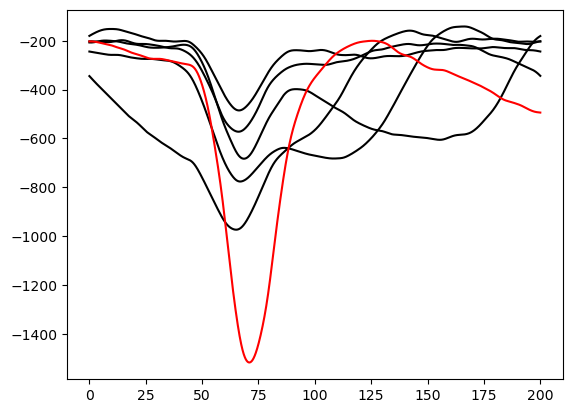

In [111]:
window_before = 50*ms
window_after = 150*ms

standard_epochs = []
deviant_epochs = []
for stimulus_time in impulse_times:
    before_time = round((stimulus_time-window_before)/defaultclock.dt)
    after_time = round((stimulus_time+window_after)/defaultclock.dt)
    if 0 <= before_time < len(combined_rate) and 0 < after_time <= len(combined_rate):
        epoch = combined_rate[before_time:after_time]
        if stimulus_time in deviant_times:
            deviant_epochs.append(epoch)
        else:
            standard_epochs.append(epoch)
standard_epochs = np.array(standard_epochs)*amp
deviant_epochs = np.array(deviant_epochs)*amp

plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), -standard_epochs.T, label='Standard', c='k');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), -deviant_epochs.T, label='Deviant', c='r');

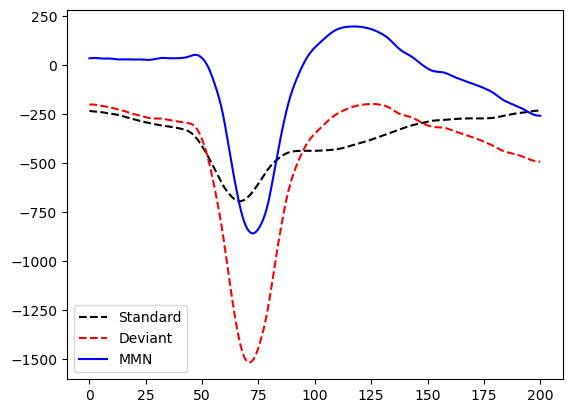

In [112]:
standard_signal = np.mean(standard_epochs, axis=0)
deviant_signal = np.mean(deviant_epochs, axis=0)

plt.figure()
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), -standard_signal, label='Standard', c='k', ls='--');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), -deviant_signal, label='Deviant', c='r', ls='--');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), -(deviant_signal - standard_signal), label='MMN', c='b');
plt.legend();

### Synaptic Currents

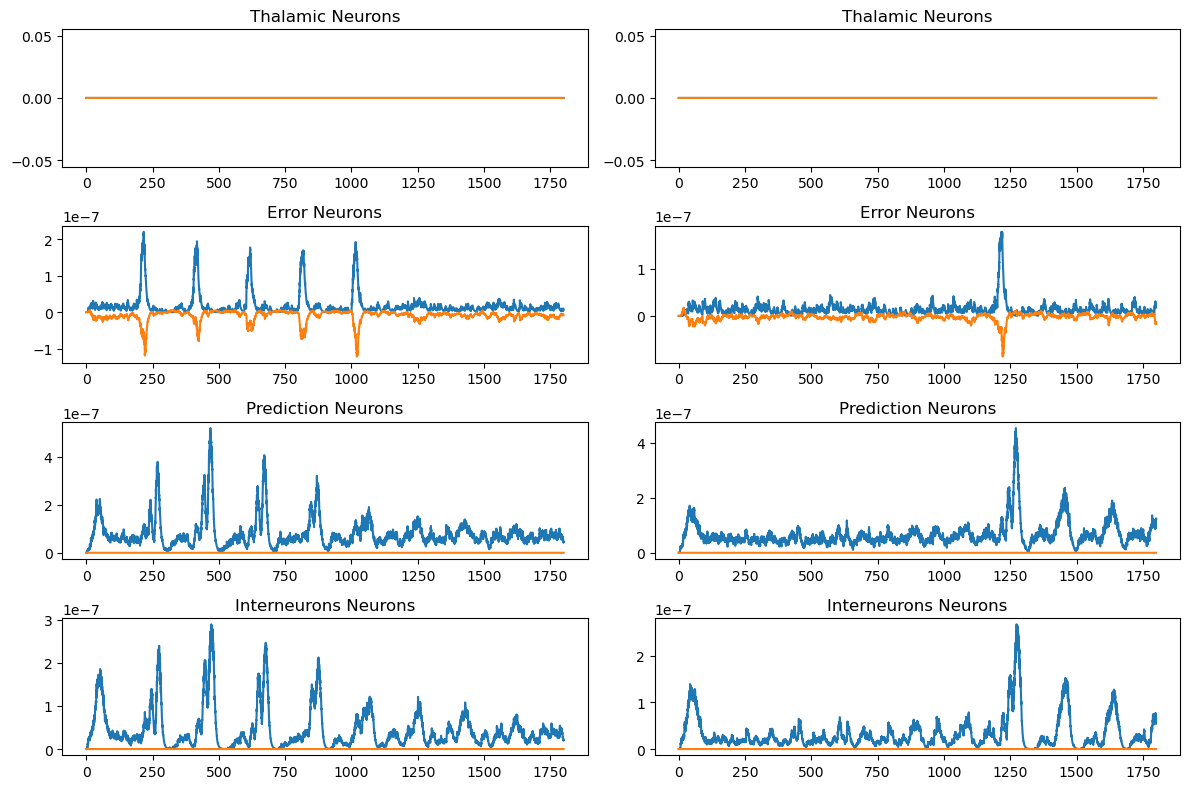

In [17]:
# Level-1
# trial = 1
bin_width = 50
neuron_types = ['thalamic', 'error', 'prediction', 'interneurons']
titles = ['Thalamic Neurons', 'Error Neurons', 'Prediction Neurons', 'Interneurons Neurons']

plt.figure(figsize=(12, 8))
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L1_monitors']['column_1'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L1_monitors']['column_1'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L1_monitors']['column_2'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L1_monitors']['column_2'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])
plt.tight_layout()

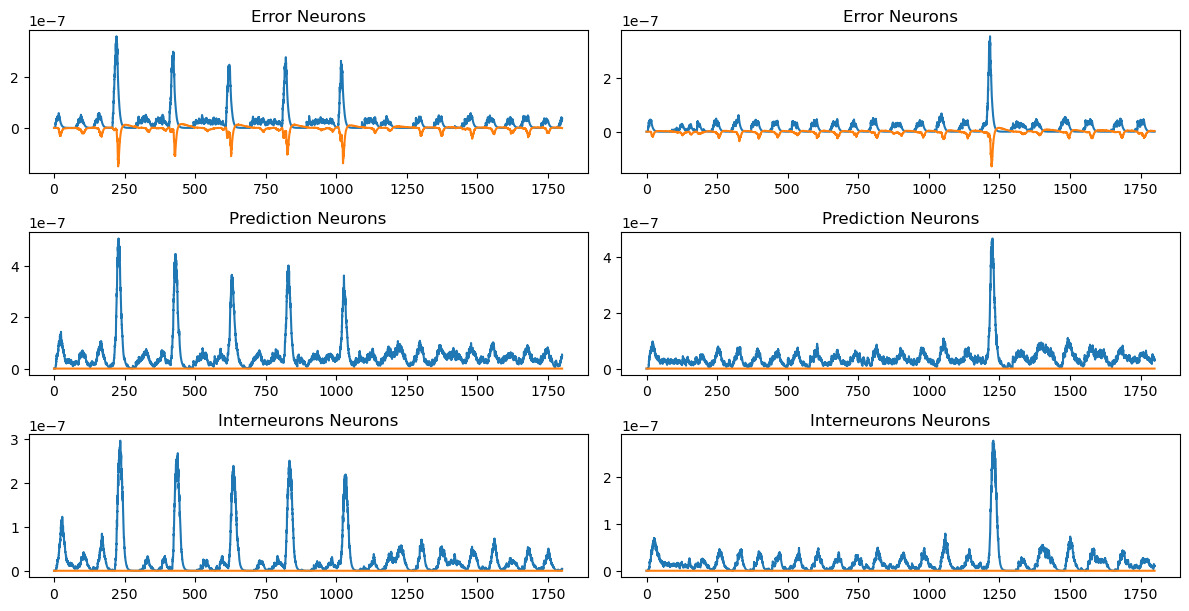

In [124]:
# Level-2

bin_width = 50
neuron_types = ['error', 'prediction', 'interneurons']
titles = ['Error Neurons', 'Prediction Neurons', 'Interneurons Neurons']

plt.figure(figsize=(12, 8))
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L2_monitors']['column_1'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L2_monitors']['column_1'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L2_monitors']['column_2'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L2_monitors']['column_2'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])
plt.tight_layout()

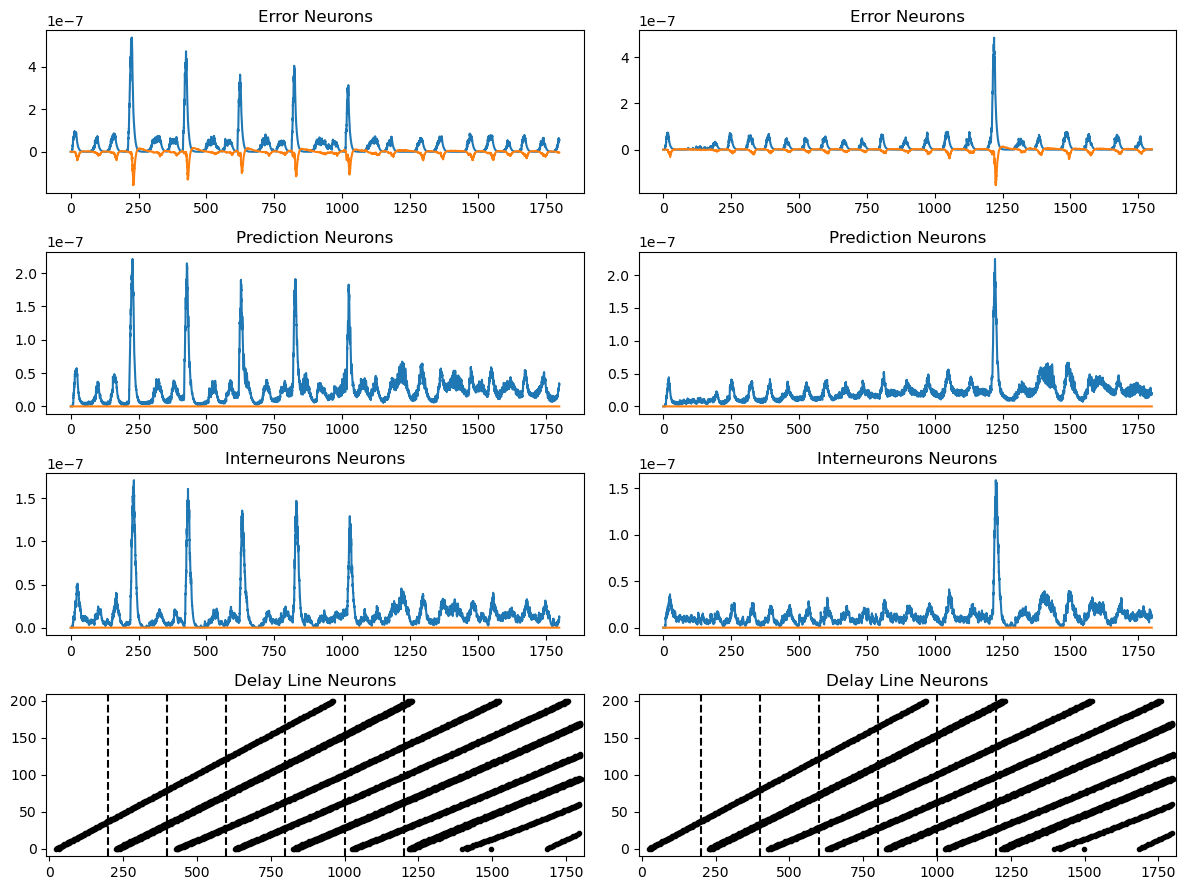

In [125]:
# Level-3

bin_width = 50
neuron_types = ['error', 'prediction', 'interneurons']
titles = ['Error Neurons', 'Prediction Neurons', 'Interneurons Neurons']

plt.figure(figsize=(12, 9))
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L3_monitors']['column_1'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L3_monitors']['column_1'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L3_monitors']['column_2'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L3_monitors']['column_2'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])

# Plot the spikes of the delay line neurons
plt.subplot(4,2,7)
plot(simulation_data[trial]['memory_networks']['memory_network_1']['spike_times']/ms,
     simulation_data[trial]['memory_networks']['memory_network_1']['spike_indices'], '.k')
for time in impulse_times:
    plt.axvline(time/ms, c='k', ls='--')
plt.title('Delay Line Neurons')
plt.xlim(-10, simulation_time/ms + 10)

plt.subplot(4,2,8)
plot(simulation_data[trial]['memory_networks']['memory_network_2']['spike_times']/ms,
     simulation_data[trial]['memory_networks']['memory_network_2']['spike_indices'], '.k')
for time in impulse_times:
    plt.axvline(time/ms, c='k', ls='--')
plt.title('Delay Line Neurons')
plt.xlim(-10, simulation_time/ms + 10)
plt.tight_layout()

### ERP Analysis

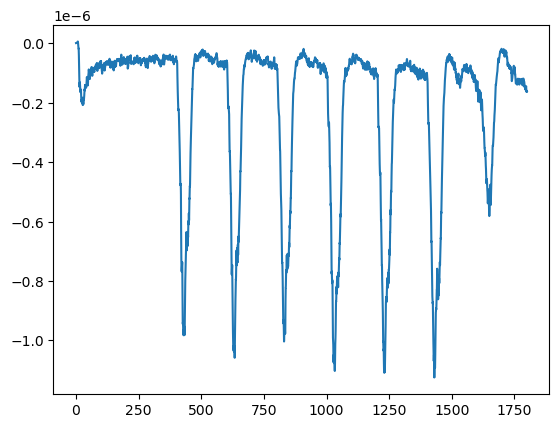

In [21]:
I_AMPA_err, I_GABA_err = get_currents(simulation_data[trial], neuron_group='error')
I_AMPA_pred, I_GABA_pred = get_currents(simulation_data[trial], neuron_group='prediction')
eeg_proxy = compute_erp_proxy(I_AMPA_err, I_GABA_err, I_AMPA_pred, I_GABA_pred)
eeg_proxy = savgol_filter(eeg_proxy / pA, 20, 3, 0)*pA
time_axis = simulation_data[trial]['sim_time']/ms
plot(time_axis, eeg_proxy);

Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


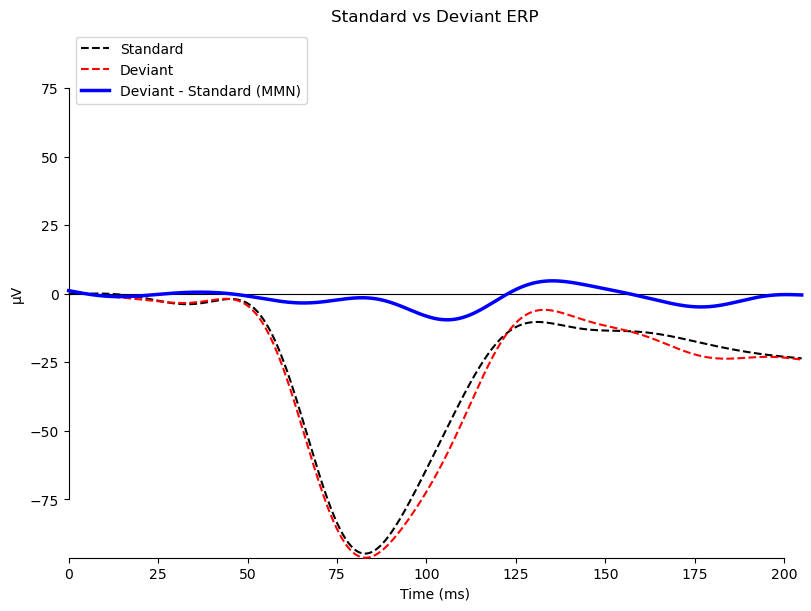

In [22]:
# %matplotlib qt
baseline_time = (-0.05, -0.04)
tmin = -0.05
sfreq = 10000
ISI = 200*ms
samples_per_epoch = int(ISI/ms*10 + abs(baseline_time[0] * 1000))
offset = int(abs(tmin) * sfreq)
n_epochs = (len(eeg_proxy) // int(ISI / ms * sfreq / 1000)) - 1

data = np.empty((n_epochs, 1, samples_per_epoch))
for i in range(n_epochs):
    stim_sample = int((i + 1) * ISI / ms * sfreq / 1000)
    start = stim_sample - offset
    end = start + samples_per_epoch
    data[i, 0, :] = eeg_proxy[start:end] * 100 / amp
    
info = mne.create_info(ch_names=['EEG_proxy'], sfreq=sfreq, ch_types=['eeg'])
events = np.array([[int((i + 1) * ISI / ms * sfreq / 1000), 0, 1] for i in range(n_epochs)])

# Mark deviants
for event in events:
    if not event[0]/10.0 in impulse_times/ms:
        event[-1] = 0
for deviant_time in deviant_times / ms:
    stim_sample = int(deviant_time * sfreq / 1000)
    idx = np.where(events[:, 0] == stim_sample)[0]
    if len(idx) > 0:
        events[idx[0], -1] = 2

epochs = mne.EpochsArray(data, info, events, tmin=tmin, baseline=baseline_time, event_id={'standard': 1, 'deviant': 2, 'blank': 0})
epochs_filtered = epochs.copy().filter(1., 30., picks=None, method='iir', iir_params=dict(order=6, ftype="butter"))

evoked_standard = epochs_filtered['standard'].average().shift_time(abs(tmin), relative=True).apply_baseline((0, 0.01))
evoked_deviant = epochs_filtered['deviant'].average().shift_time(abs(tmin), relative=True).apply_baseline((0, 0.01))
evoked_diff = mne.combine_evoked([evoked_deviant, evoked_standard], weights=[1, -1])
mne.viz.plot_compare_evokeds(
    {'Standard': evoked_standard, 'Deviant': evoked_deviant, 'Deviant - Standard (MMN)': evoked_diff},
    picks='EEG_proxy',
    colors={'Standard': 'black', 'Deviant': 'red', 'Deviant - Standard (MMN)': 'blue'},
    styles={'Standard': {'linestyle': '--', 'linewidth': 1.5},'Deviant': {'linestyle': '--', 'linewidth': 1.5},
        'Deviant - Standard (MMN)': {'linestyle': '-', 'linewidth': 2.5}},
    title='Standard vs Deviant ERP',
    time_unit='ms',
    show_sensors=False,
    # ylim=dict(eeg=[-30, 25])
);

In [33]:
# %matplotlib inline

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
No baseline correction applied


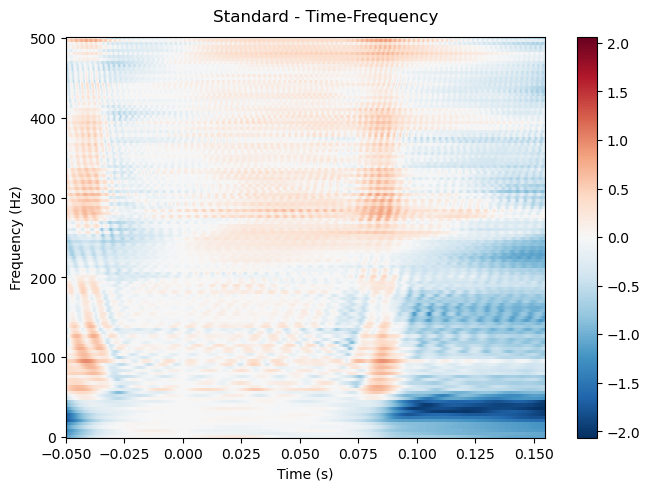

No baseline correction applied


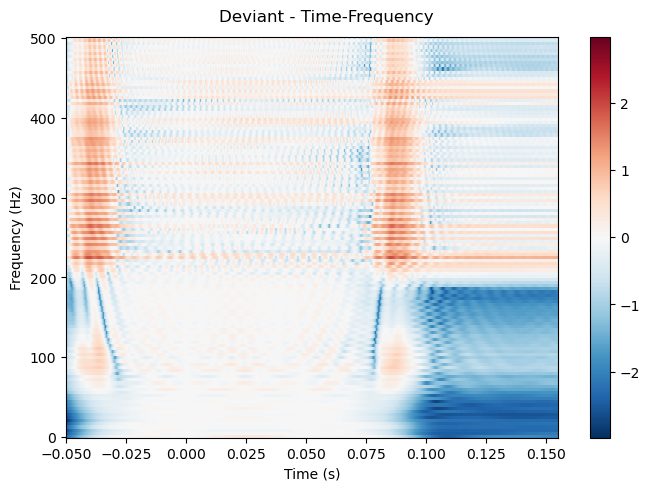

No baseline correction applied


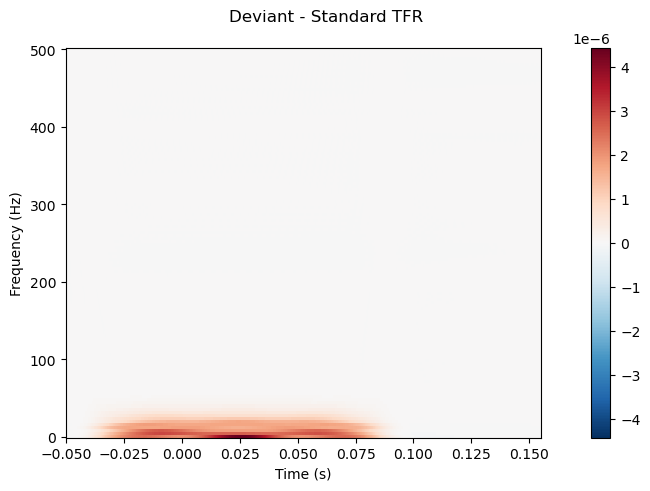

[<Figure size 640x480 with 2 Axes>]

In [118]:
# Parameters for TFR
freqs = np.linspace(1, 500, 128)  # Frequencies from 1–40 Hz
n_cycles = freqs / 8.  # number of cycles in each frequency
baseline = (0.0, 0)   # 100 ms pre-stimulus baseline
power_standard = epochs['standard'].compute_tfr(
    freqs=freqs,
    n_cycles=n_cycles,
    method="multitaper",
    use_fft=True,
    return_itc=False,
    average=True
)

power_deviant = epochs['deviant'].compute_tfr(
    freqs=freqs,
    n_cycles=n_cycles,
    method="multitaper",
    use_fft=True,
    return_itc=False,
    average=True
)
power_diff = power_deviant.copy()
power_diff.data -= power_standard.data
power_standard.apply_baseline(baseline=baseline, mode='logratio')
power_deviant.apply_baseline(baseline=baseline, mode='logratio')

power_standard.plot(picks='EEG_proxy', title='Standard - Time-Frequency')
power_deviant.plot(picks='EEG_proxy', title='Deviant - Time-Frequency')
power_diff.plot(picks='EEG_proxy', title='Deviant - Standard TFR')

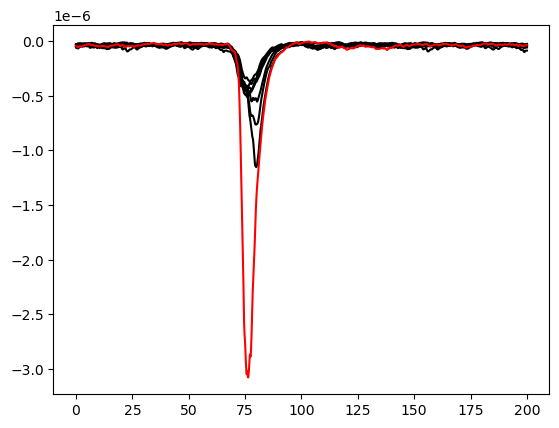

In [30]:
window_before = 100*ms
window_after = 200*ms

standard_epochs = []
deviant_epochs = []
for stimulus_time in impulse_times:
    before_time = round((stimulus_time-window_before)/defaultclock.dt)
    after_time = round((stimulus_time+window_after)/defaultclock.dt)
    if 0 <= before_time < len(eeg_proxy) and 0 < after_time <= len(eeg_proxy):
        epoch = eeg_proxy[before_time:after_time]
        if stimulus_time in deviant_times:
            deviant_epochs.append(epoch)
        else:
            standard_epochs.append(epoch)
standard_epochs = np.array(standard_epochs)*amp
deviant_epochs = np.array(deviant_epochs)*amp

plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), standard_epochs.T, label='Standard', c='k');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), deviant_epochs.T, label='Deviant', c='r');

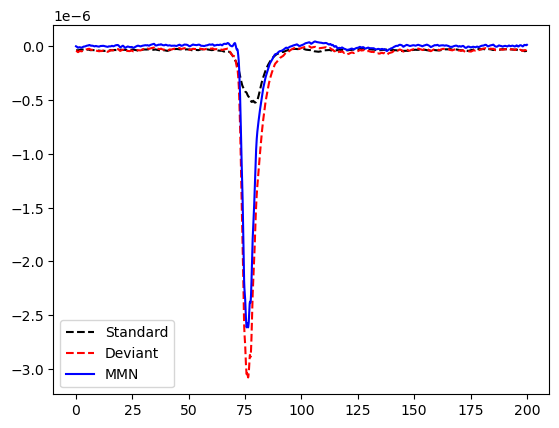

In [31]:
standard_signal = np.mean(standard_epochs, axis=0)
deviant_signal = np.mean(deviant_epochs, axis=0)

plt.figure()
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), standard_signal, label='Standard', c='k', ls='--');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), deviant_signal, label='Deviant', c='r', ls='--');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), (deviant_signal - standard_signal), label='MMN', c='b');
plt.legend();

## Multi-simulation Analysis

In [134]:
import re

model='CO'
N = 40
num_simulations = 1
simulation_folder = 'higher_conn'
simulation_time = 1.8*second
stimulus_time=20*ms
smoothing_width=20*ms

impulse_times = np.arange(200, 1900, 200)*ms
deviant_times = np.array([1800])*ms

EH = []
PL = []
MMN = []

list_of_files = glob.glob(f'./simulation_data/{simulation_folder}/{model}*', recursive=True)
list_of_files = sorted(list_of_files, key=os.path.getctime)

for file in list_of_files:
    match = re.search(r'EH([0-9.]+)_PL([0-9.]+)', file)
    if match:
        EH.append(float(match.group(1)))
        PL.append(float(match.group(2)))
    sim_data = get_currents_data(file)
    I_AMPA_err, I_GABA_err = get_currents(sim_data['Trial_1'], neuron_group='error')
    I_AMPA_pred, I_GABA_pred = get_currents(sim_data['Trial_1'], neuron_group='prediction')
    eeg_proxy = compute_erp_proxy(I_AMPA_err, I_GABA_err, I_AMPA_pred, I_GABA_pred)
    eeg_proxy = savgol_filter(eeg_proxy / pA, 20, 3, 0)*pA
    MMN.append(min(eeg_proxy[14000:]))
    print(MMN)
    break

[-0.7781078 * uamp]


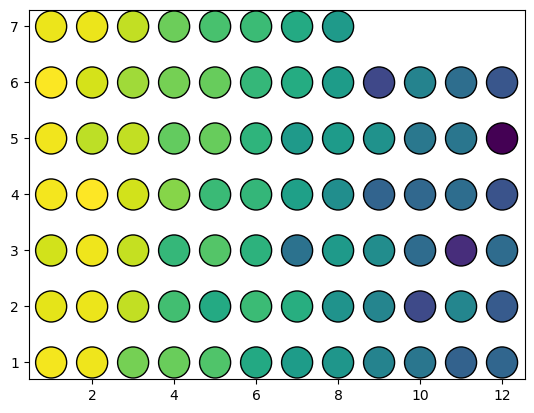

In [58]:
plt.scatter(EH, PL, c=MMN, cmap='viridis', s=500, edgecolor='k')

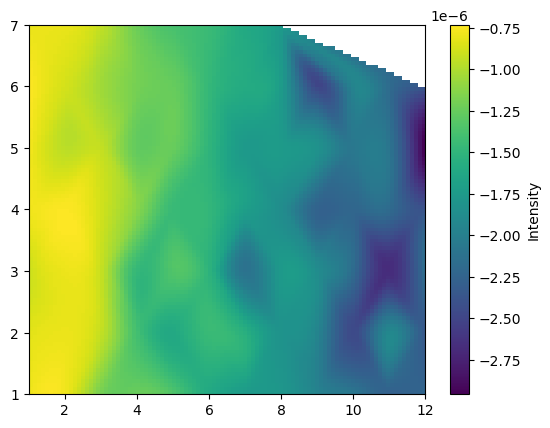

In [59]:
from scipy.interpolate import griddata

xi = np.linspace(min(EH), max(EH), 100)
yi = np.linspace(min(PL), max(PL), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((EH, PL), MMN, (xi, yi), method='cubic')

plt.imshow(zi, extent=(min(EH), max(EH), min(PL), max(PL)),
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Intensity')

## Plot STDP Weights

In [ ]:
trial = 'Trial_1'

In [ ]:
for deviant_time in deviant_times_10:
    index = np.where(impulse_times == deviant_time)[0][0]
    index=99
    smoothed_weights = gaussian_filter1d(simulation_data[trial]['self_memory_weights']['column_1'][index, :], sigma=5)
    plt.figure()
    plt.scatter(np.arange(simulation_data[trial]['self_memory_weights']['column_1'][index, :].shape[0]),
            smoothed_weights)
    plt.xlim(0, 6000)
    plt.title(f'Deviant time: {deviant_time}')

In [ ]:
for deviant_time in deviant_times_10:
    index = np.where(impulse_times == deviant_time)[0][0]
    index=99
    smoothed_weights = gaussian_filter1d(simulation_data[trial]['other_memory_weights']['column_1'][index, :], sigma=5)
    plt.figure()
    plt.scatter(np.arange(simulation_data[trial]['other_memory_weights']['column_1'][index, :].shape[0]),
            smoothed_weights)
    plt.xlim(0, 6000)
    plt.title(f'Deviant time: {deviant_time}')

In [ ]:
simulation_pre_ids = simulation_data[trial]['self_weight_connections']['column_1'][:, 0]
pre_ids = simulation_data[trial]['self_weight_connections']['column_1'][:, 0]
post_ids = simulation_data[trial]['self_weight_connections']['column_1'][:, 1]
weight_matrix = simulation_data[trial]['self_memory_weights']['column_1']

n_frames = weight_matrix.shape[0]
n_pre = pre_ids.max() + 1
n_post = post_ids.max() + 1

fig, ax = plt.subplots(figsize=(8, 6))

img = None
def update(frame):
    global img
    wgt_list = weight_matrix[frame, :] - weight_matrix[0, :]
    W = coo_matrix((wgt_list, (post_ids, pre_ids)), shape=(n_post, n_pre)).toarray()
    if img is None:
        img = ax.imshow(W, aspect='auto', cmap='bwr', vmin=0, vmax=weight_matrix.max())
    else:
        img.set_data(W)
    return [img]

anim = FuncAnimation(fig, update, frames=n_frames, interval=200, blit=True)
HTML(anim.to_jshtml())

In [ ]:
simulation_pre_ids = simulation_data[trial]['other_weight_connections']['column_1'][:, 0]
pre_ids = simulation_data[trial]['other_weight_connections']['column_1'][:, 0]
post_ids = simulation_data[trial]['other_weight_connections']['column_1'][:, 1]
weight_matrix = simulation_data[trial]['other_memory_weights']['column_1']

n_frames = weight_matrix.shape[0]
n_pre = pre_ids.max() + 1
n_post = post_ids.max() + 1

fig, ax = plt.subplots(figsize=(8, 6))

img = None
def update(frame):
    global img
    wgt_list = weight_matrix[frame, :] - weight_matrix[0, :]
    W = coo_matrix((wgt_list, (post_ids, pre_ids)), shape=(n_post, n_pre)).toarray()
    if img is None:
        img = ax.imshow(W, aspect='auto', cmap='bwr', vmin=0, vmax=weight_matrix.max())
    else:
        img.set_data(W)
    return [img]

anim = FuncAnimation(fig, update, frames=n_frames, interval=200, blit=True)
HTML(anim.to_jshtml())

## Spiking Activity

In [ ]:
trial = 'Trial_1'
plt.figure(figsize=(12,7))
plt.subplot(3,2,1)
plot(simulation_data[trial]['L1_monitors']['column_1']['error']['spike_times']/ms,
     simulation_data[trial]['L1_monitors']['column_1']['error']['spike_indices'], '.k');
plt.xlim(0, simulation_time/ms)
plt.subplot(3,2,3)
plot(simulation_data[trial]['L2_monitors']['column_1']['error']['spike_times']/ms,
     simulation_data[trial]['L2_monitors']['column_1']['error']['spike_indices'], '.k');
plt.xlim(0, simulation_time/ms)
plt.subplot(3,2,5)
plot(simulation_data[trial]['L3_monitors']['column_1']['error']['spike_times']/ms,
     simulation_data[trial]['L3_monitors']['column_1']['error']['spike_indices'], '.k');
plt.xlim(0, simulation_time/ms)
# plt.tight_layout()

plt.subplot(3,2,2)
plot(simulation_data[trial]['sim_time']/ms,
     np.mean(simulation_data[trial]['L1_monitors']['column_1']['err_stsd_term'], axis=0))
plt.axhline(0.5, c='r')
plt.ylim(0, 1)
plt.tight_layout()
plt.subplot(3,2,4)
plot(simulation_data[trial]['sim_time']/ms,
     np.mean(simulation_data[trial]['L2_monitors']['column_1']['err_stsd_term'], axis=0))
plt.axhline(0.5, c='r')
plt.ylim(0, 1)
plt.subplot(3,2,6)
plot(simulation_data[trial]['sim_time']/ms,
     np.mean(simulation_data[trial]['L3_monitors']['column_1']['err_stsd_term'], axis=0))
plt.axhline(0.5, c='r')
plt.ylim(0, 1)
plt.tight_layout()

## Statistics per Population

In [ ]:
trial = 'Trial_1'

In [ ]:
# Population Firing Rate (for now just trajectories based on rates only)
L1C1_E_rate = simulation_data[trial]['L1_monitors']['column_1']['error']['rate']
L1C1_P_rate = simulation_data[trial]['L1_monitors']['column_1']['prediction']['rate']
L1C1_I_rate = simulation_data[trial]['L1_monitors']['column_1']['interneurons']['rate']

L1C2_E_rate = simulation_data[trial]['L1_monitors']['column_2']['error']['rate']
L1C2_P_rate = simulation_data[trial]['L1_monitors']['column_2']['prediction']['rate']
L1C2_I_rate = simulation_data[trial]['L1_monitors']['column_2']['interneurons']['rate']

L2C1_E_rate = simulation_data[trial]['L2_monitors']['column_1']['error']['rate']
L2C1_P_rate = simulation_data[trial]['L2_monitors']['column_1']['prediction']['rate']
L2C1_I_rate = simulation_data[trial]['L2_monitors']['column_1']['interneurons']['rate']

L2C2_E_rate = simulation_data[trial]['L2_monitors']['column_2']['error']['rate']
L2C2_P_rate = simulation_data[trial]['L2_monitors']['column_2']['prediction']['rate']
L2C2_I_rate = simulation_data[trial]['L2_monitors']['column_2']['interneurons']['rate']

# AMPA currents
L1C1_E_AMPA = np.sum(simulation_data[trial]['L1_monitors']['column_1']['error']['I_AMPA']/nA, axis=0)
L1C1_P_AMPA = np.sum(simulation_data[trial]['L1_monitors']['column_1']['prediction']['I_AMPA']/nA, axis=0)
L1C1_I_AMPA = np.sum(simulation_data[trial]['L1_monitors']['column_1']['interneurons']['I_AMPA']/nA, axis=0)

L1C2_E_AMPA = np.sum(simulation_data[trial]['L1_monitors']['column_2']['error']['I_AMPA']/nA, axis=0)
L1C2_P_AMPA = np.sum(simulation_data[trial]['L1_monitors']['column_2']['prediction']['I_AMPA']/nA, axis=0)
L1C2_I_AMPA = np.sum(simulation_data[trial]['L1_monitors']['column_2']['interneurons']['I_AMPA']/nA, axis=0)

L2C1_E_AMPA = np.sum(simulation_data[trial]['L2_monitors']['column_1']['error']['I_AMPA']/nA, axis=0)
L2C1_P_AMPA = np.sum(simulation_data[trial]['L2_monitors']['column_1']['prediction']['I_AMPA']/nA, axis=0)
L2C1_I_AMPA = np.sum(simulation_data[trial]['L2_monitors']['column_1']['interneurons']['I_AMPA']/nA, axis=0)

L2C2_E_AMPA = np.sum(simulation_data[trial]['L2_monitors']['column_2']['error']['I_AMPA']/nA, axis=0)
L2C2_P_AMPA = np.sum(simulation_data[trial]['L2_monitors']['column_2']['prediction']['I_AMPA']/nA, axis=0)
L2C2_I_AMPA = np.sum(simulation_data[trial]['L2_monitors']['column_2']['interneurons']['I_AMPA']/nA, axis=0)

In [ ]:
from scipy.signal import convolve
from scipy.optimize import curve_fit

def smooth_epoch(epoch, kernel_size=9):
    kernel = np.exp(-np.linspace(-2, 2, kernel_size)**2)
    kernel /= kernel.sum()
    return convolve(epoch, kernel, mode='same')
    
def get_epochs(rate):
    window_before = 100*ms
    window_after = 100*ms
    epochs = []
    for stimulus_time in impulse_times:
        before_time = round((stimulus_time-window_before)/defaultclock.dt)
        after_time = round((stimulus_time+window_after)/defaultclock.dt)
        if 0 <= before_time < len(rate) and 0 < after_time <= len(rate):
            epoch = rate[before_time:after_time]
            epoch = gaussian_filter(epoch, 500)
            epochs.append(epoch)
    epochs = np.array(epochs)*amp
    return epochs

L1C1_E_epochs = get_epochs(simulation_data[trial]['L1_monitors']['column_1']['error']['rate'])
L1C1_P_epochs = get_epochs(simulation_data[trial]['L1_monitors']['column_1']['prediction']['rate'])
L1C1_I_epochs = get_epochs(simulation_data[trial]['L1_monitors']['column_1']['interneurons']['rate'])

In [ ]:
plot(gaussian_filter(L1C1_E_rate, 200));

In [ ]:
trajectory = np.array([smooth_epoch(L1C1_E_rate, 300),
                       smooth_epoch(L1C1_P_rate, 300),
                       smooth_epoch(L1C1_I_rate, 300)])
trajectory_df = pd.DataFrame(trajectory.T, columns=['C1_E_rate', 'C1_P_rate', 'C1_I_rate'])
trajectory_df['time'] = np.arange(0,L1C1_E_rate.shape[0])
trajectory_df

In [ ]:
import plotly.graph_objects as go  # Note: you should use plotly.graph_objects here

fig = go.Figure(data=go.Scatter3d(
    x=trajectory_df['C1_E_rate'], 
    y=trajectory_df['C1_P_rate'], 
    z=trajectory_df['C1_I_rate'],
    marker=dict(
        size=2,
        color=trajectory_df['time'],
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
))

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    scene=dict(
        xaxis_title='Error Rate (E)',
        yaxis_title='Prediction Rate (P)',
        zaxis_title='Inhibition Rate (I)',
        # aspectmode='cube',
        aspectratio=dict(x=1, y=1, z=0.2)
    )
)

fig.show()


## Population Rate Plot

In [ ]:
# Level-1
neuron_types = ['thalamic', 'error', 'prediction', 'interneurons']
titles = ['Thalamic Neurons', 'Error Neurons', 'Prediction Neurons', 'Inhibitory Interneurons']

plt.figure(figsize=(10, 16))
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(8, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time'], 
         simulation_data[trial]['L1_monitors']['column_1'][neuron_type]['rate'])
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(8, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time'], 
         simulation_data[trial]['L1_monitors']['column_2'][neuron_type]['rate'])
    plt.title(titles[i])
plt.tight_layout()

In [ ]:
# Level-2
neuron_types = ['error', 'prediction', 'interneurons']
titles = ['Error Neurons', 'Prediction Neurons', 'Inhibitory Interneurons']

plt.figure(figsize=(10, 16))
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(8, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time'], 
         simulation_data[trial]['L2_monitors']['column_1'][neuron_type]['rate'])
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(8, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time'], 
         simulation_data[trial]['L2_monitors']['column_2'][neuron_type]['rate'])
    plt.title(titles[i])
plt.tight_layout()

In [ ]:
# Level-3
neuron_types = ['error', 'prediction', 'interneurons']
titles = ['Error Neurons', 'Prediction Neurons', 'Inhibitory Interneurons']

plt.figure(figsize=(10, 16))

for i, neuron_type in enumerate(neuron_types):
    plt.subplot(8, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time']/ms, 
         simulation_data[trial]['L3_monitors']['column_1'][neuron_type]['rate'])
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(8, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time']/ms, 
         simulation_data[trial]['L3_monitors']['column_2'][neuron_type]['rate'])
    plt.title(titles[i])

# Plot the spikes of the delay line neurons
plt.subplot(8,2,7)
plot(simulation_data[trial]['memory_networks']['memory_network_1']['spike_times']/ms,
     simulation_data[trial]['memory_networks']['memory_network_1']['spike_indices'], '.k')
for time in impulse_times:
    plt.axvline(time/ms, c='k', ls='--')
plt.title('Delay Line Neurons')
plt.xlim(-10, simulation_time/ms + 10)

plt.subplot(8,2,8)
plot(simulation_data[trial]['memory_networks']['memory_network_2']['spike_times']/ms,
     simulation_data[trial]['memory_networks']['memory_network_2']['spike_indices'], '.k')
for time in impulse_times:
    plt.axvline(time/ms, c='k', ls='--')
plt.title('Delay Line Neurons')
plt.xlim(-10, simulation_time/ms + 10)
plt.tight_layout()

In [ ]:
# Combined rate
combined_rate = np.zeros(round(simulation_time/defaultclock.dt))*Hz
combined_rate += (simulation_data[trial]['L1_monitors']['column_1']['error']['rate'] + \
                     simulation_data[trial]['L1_monitors']['column_2']['error']['rate'] + \
                     simulation_data[trial]['L2_monitors']['column_1']['error']['rate'] + \
                     simulation_data[trial]['L2_monitors']['column_2']['error']['rate'] + \
                     simulation_data[trial]['L3_monitors']['column_1']['error']['rate'] + \
                     simulation_data[trial]['L3_monitors']['column_2']['error']['rate'] + \
                     simulation_data[trial]['L1_monitors']['column_1']['prediction']['rate'] + \
                     simulation_data[trial]['L1_monitors']['column_2']['prediction']['rate'] + \
                     simulation_data[trial]['L2_monitors']['column_1']['prediction']['rate'] + \
                     simulation_data[trial]['L2_monitors']['column_2']['prediction']['rate'] + \
                     simulation_data[trial]['L3_monitors']['column_1']['prediction']['rate'] + \
                     simulation_data[trial]['L3_monitors']['column_2']['prediction']['rate']
                 )/num_simulations
time_axis = simulation_data[trial]['sim_time']/ms

combined_rate = gaussian_filter1d(combined_rate, sigma=3)
plot(time_axis, combined_rate);

In [ ]:
window_before = 50*ms
window_after = 150*ms

standard_epochs = []
deviant_epochs = []
for stimulus_time in impulse_times:
    before_time = round((stimulus_time-window_before)/defaultclock.dt)
    after_time = round((stimulus_time+window_after)/defaultclock.dt)
    if 0 <= before_time < len(combined_rate) and 0 < after_time <= len(combined_rate):
        epoch = combined_rate[before_time:after_time]
        if stimulus_time in deviant_times_10:
            deviant_epochs.append(epoch)
        else:
            standard_epochs.append(epoch)
standard_epochs = np.array(standard_epochs)*amp
deviant_epochs = np.array(deviant_epochs)*amp

plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), -standard_epochs.T, label='Standard', c='k');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), -deviant_epochs.T, label='Deviant', c='r');

In [ ]:
standard_signal = np.mean(standard_epochs, axis=0)
deviant_signal = np.mean(deviant_epochs, axis=0)

plt.figure()
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), -standard_signal, label='Standard', c='k', ls='--');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), -deviant_signal, label='Deviant', c='r', ls='--');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), -(deviant_signal - standard_signal), label='MMN', c='b');
plt.legend();

## Synaptic Currents

In [ ]:
# Level-1
# trial = 1
bin_width = 50
neuron_types = ['thalamic', 'error', 'prediction', 'interneurons']
titles = ['Thalamic Neurons', 'Error Neurons', 'Prediction Neurons', 'Interneurons Neurons']

plt.figure(figsize=(12, 8))
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L1_monitors']['column_1'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L1_monitors']['column_1'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L1_monitors']['column_2'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L1_monitors']['column_2'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])
plt.tight_layout()

In [ ]:
# Level-2

bin_width = 50
neuron_types = ['error', 'prediction', 'interneurons']
titles = ['Error Neurons', 'Prediction Neurons', 'Interneurons Neurons']

plt.figure(figsize=(12, 8))
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L2_monitors']['column_1'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L2_monitors']['column_1'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L2_monitors']['column_2'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L2_monitors']['column_2'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])
plt.tight_layout()

In [ ]:
# Level-3

bin_width = 50
neuron_types = ['error', 'prediction', 'interneurons']
titles = ['Error Neurons', 'Prediction Neurons', 'Interneurons Neurons']

plt.figure(figsize=(12, 9))
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1)-1)
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L3_monitors']['column_1'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L3_monitors']['column_1'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])
for i, neuron_type in enumerate(neuron_types):
    plt.subplot(4, 2, 2*(i+1))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L3_monitors']['column_2'][neuron_type]['I_AMPA'], axis=0))
    plot(simulation_data[trial]['sim_time']/ms, 
         np.sum(simulation_data[trial]['L3_monitors']['column_2'][neuron_type]['I_GABA'], axis=0))
    plt.title(titles[i])

# Plot the spikes of the delay line neurons
plt.subplot(4,2,7)
plot(simulation_data[trial]['memory_networks']['memory_network_1']['spike_times']/ms,
     simulation_data[trial]['memory_networks']['memory_network_1']['spike_indices'], '.k')
for time in impulse_times:
    plt.axvline(time/ms, c='k', ls='--')
plt.title('Delay Line Neurons')
plt.xlim(-10, simulation_time/ms + 10)

plt.subplot(4,2,8)
plot(simulation_data[trial]['memory_networks']['memory_network_2']['spike_times']/ms,
     simulation_data[trial]['memory_networks']['memory_network_2']['spike_indices'], '.k')
for time in impulse_times:
    plt.axvline(time/ms, c='k', ls='--')
plt.title('Delay Line Neurons')
plt.xlim(-10, simulation_time/ms + 10)
plt.tight_layout()

## Get ERP

In [ ]:
%matplotlib qt
baseline_time = (-0.05, -0.04)
tmin = -0.05
sfreq = 10000
ISI = 200*ms
samples_per_epoch = int(ISI/ms*10 + abs(baseline_time[0] * 1000))
offset = int(abs(tmin) * sfreq)
n_epochs = (len(eeg_proxy) // int(ISI / ms * sfreq / 1000)) - 1

data = np.empty((n_epochs, 1, samples_per_epoch))
for i in range(n_epochs):
    stim_sample = int((i + 1) * ISI / ms * sfreq / 1000)
    start = stim_sample - offset
    end = start + samples_per_epoch
    data[i, 0, :] = eeg_proxy[start:end] * 100 / amp
    
info = mne.create_info(ch_names=['EEG_proxy'], sfreq=sfreq, ch_types=['eeg'])
events = np.array([[int((i + 1) * ISI / ms * sfreq / 1000), 0, 1] for i in range(n_epochs)])

# Mark deviants
for event in events:
    if not event[0]/10.0 in impulse_times/ms:
        event[-1] = 0
for deviant_time in deviant_times_10 / ms:
    stim_sample = int(deviant_time * sfreq / 1000)
    idx = np.where(events[:, 0] == stim_sample)[0]
    if len(idx) > 0:
        events[idx[0], -1] = 2
print(events.shape)
print(data.shape)
epochs = mne.EpochsArray(data, info, events, tmin=tmin, baseline=baseline_time, event_id={'standard': 1, 'deviant': 2, 'blank': 0})
epochs_filtered = epochs.copy().filter(1., 30., picks=None, method='iir', iir_params=dict(order=6, ftype="butter"))

evoked_standard = epochs_filtered['standard'].average().shift_time(abs(tmin), relative=True).apply_baseline((0, 0.01))
evoked_deviant = epochs_filtered['deviant'].average().shift_time(abs(tmin), relative=True).apply_baseline((0, 0.01))
evoked_diff = mne.combine_evoked([evoked_deviant, evoked_standard], weights=[1, -1])
mne.viz.plot_compare_evokeds(
    {'Standard': evoked_standard, 'Deviant': evoked_deviant, 'Deviant - Standard (MMN)': evoked_diff},
    picks='EEG_proxy',
    colors={'Standard': 'black', 'Deviant': 'red', 'Deviant - Standard (MMN)': 'blue'},
    styles={'Standard': {'linestyle': '--', 'linewidth': 1.5},'Deviant': {'linestyle': '--', 'linewidth': 1.5},
        'Deviant - Standard (MMN)': {'linestyle': '-', 'linewidth': 2.5}},
    title='Standard vs Deviant ERP',
    time_unit='ms',
    show_sensors=False,
    ylim=dict(eeg=[-30, 25])
);

In [ ]:
%matplotlib inline

In [ ]:
from mne.time_frequency import tfr_multitaper

# Parameters for TFR
freqs = np.linspace(1, 500, 128)  # Frequencies from 1–40 Hz
n_cycles = freqs / 8.  # number of cycles in each frequency
baseline = (0.0, 0)   # 100 ms pre-stimulus baseline
power_standard = epochs['standard'].compute_tfr(
    freqs=freqs,
    n_cycles=n_cycles,
    method="multitaper",
    use_fft=True,
    return_itc=False,
    average=True
)

power_deviant = epochs['deviant'].compute_tfr(
    freqs=freqs,
    n_cycles=n_cycles,
    method="multitaper",
    use_fft=True,
    return_itc=False,
    average=True
)
power_diff = power_deviant.copy()
power_diff.data -= power_standard.data
power_standard.apply_baseline(baseline=baseline, mode='logratio')
power_deviant.apply_baseline(baseline=baseline, mode='logratio')

power_standard.plot(picks='EEG_proxy', title='Standard - Time-Frequency')
power_deviant.plot(picks='EEG_proxy', title='Deviant - Time-Frequency')
power_diff.plot(picks='EEG_proxy', title='Deviant - Standard TFR')

In [ ]:
window_before = 100*ms
window_after = 200*ms

standard_epochs = []
deviant_epochs = []
for stimulus_time in impulse_times:
    before_time = round((stimulus_time-window_before)/defaultclock.dt)
    after_time = round((stimulus_time+window_after)/defaultclock.dt)
    if 0 <= before_time < len(eeg_proxy) and 0 < after_time <= len(eeg_proxy):
        epoch = eeg_proxy[before_time:after_time]
        if stimulus_time in deviant_times_10:
            deviant_epochs.append(epoch)
        else:
            standard_epochs.append(epoch)
standard_epochs = np.array(standard_epochs)*amp
deviant_epochs = np.array(deviant_epochs)*amp

plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), standard_epochs.T, label='Standard', c='k');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), deviant_epochs.T, label='Deviant', c='r');

In [ ]:
standard_signal = np.mean(standard_epochs, axis=0)
deviant_signal = np.mean(deviant_epochs, axis=0)

plt.figure()
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), standard_signal, label='Standard', c='k', ls='--');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), deviant_signal, label='Deviant', c='r', ls='--');
plt.plot(np.linspace(0, 200, standard_epochs.shape[1]), (deviant_signal - standard_signal), label='MMN', c='b');
plt.legend();